## Targets
* resampling on face bbox coords. & facial landmarks
* Using same algorithm of alignment to get quad.
* perform inverse transformation on that

In [21]:
import pickle
import json
from random import sample
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import skimage.io as io
from PIL import Image, ImageDraw
from sklearn.decomposition import PCA

In [2]:
!ls ~/data/DeepFashion/kp_heatmaps/keypoints/train | wc -l

22204


In [3]:
!ls ~/data/DeepFashion/AB_RGBA_quad/train | wc -l

22204


In [4]:
KP_THRES = 0.05
NUM_DIM = 5
OUTPUT_SIZE = 256
ENABLE_PADDING = True
IMG_SIZE = (256, 256)

In [5]:
TRAIN_IMG_PATHS = sorted(list(Path('~/data/DeepFashion/AB_RGBA_quad/train').expanduser().glob('*.png')))
VAL_IMG_PATHS = sorted(list(Path('~/data/DeepFashion/AB_RGBA_quad/val').expanduser().glob('*.png')))
KP_FILES = {p.stem: p for p in Path('~/data/DeepFashion/kp_heatmaps/keypoints/train/').expanduser().glob('*.pkl')}

DLIB_OUTPUTS = json.load(open('./deepfashion_landmarks.json', 'r'))
to_keep = [p.stem for p in TRAIN_IMG_PATHS]
LANDMARKS = {Path(item['in_the_wild']['file_path']).stem: np.array(item['in_the_wild']['face_landmarks']) 
             for item in DLIB_OUTPUTS.values() if Path(item['in_the_wild']['file_path']).stem in to_keep}
BOXES = {Path(item['in_the_wild']['file_path']).stem: np.array(item['in_the_wild']['box']) 
             for item in DLIB_OUTPUTS.values() if Path(item['in_the_wild']['file_path']).stem in to_keep}

print(f"img: {len(TRAIN_IMG_PATHS)}, Keypoins: {len(KP_FILES)}, landmarks: {len(LANDMARKS)}")

img: 22204, Keypoins: 22204, landmarks: 22204


In [6]:
set(list(KP_FILES.keys())) == set([p.stem for p in TRAIN_IMG_PATHS]) and set([p.stem for p in TRAIN_IMG_PATHS]) == set(list(LANDMARKS.keys()))

True

### Fake Images from StyleGAN2-ada

## Helper Function

In [7]:
def draw_point(imgd, point, r=3, color="#ff0000"):
    point = point.astype(int)
    imgd.ellipse([*(point - r), *(point + r)], fill=color)
    
def draw_quad(imgd, quad, color="#ff0000"):
    display_quad = np.where(quad < 0, 0, quad).astype(int)
    print(display_quad)
    for idx in reversed(range(display_quad.shape[0])):
        imgd.line([*display_quad[idx], *display_quad[idx - 1]], fill=color)

def gallery(imgs):
    if isinstance(imgs, list):
        imgs = np.array(imgs)
    
    b, h, w, c = imgs.shape
    return imgs.transpose(1, 0, 2, 3).reshape(h, b*w, c)

## Landmarks

In [8]:
def get_observations(paths, include_box=False):
    observations = []
    headers = ['box_x1', 'box_y1', 'box_x2', 'box_y2', 'crop_x1', 'crop_y1', 'crop_x2', 'crop_y2'] if include_box else []
    headers += ['quad_x1', 'quad_y1', 'quad_x2', 'quad_y2', 'quad_x3', 'quad_y3', 'quad_x4', 'quad_y4']
    for p in paths: #sample(TRAIN_IMG_PATHS, 5):
        observation = []
        if include_box:
            x1, y1, w, h = BOXES[p.stem]
            x2, y2 = x1 + w, y1 + h
            observation = [x1/4, y1/4, x2/4, y2/4]

        lm = np.array(LANDMARKS[p.stem])
        lm_chin          = lm[0  : 17]  # left-right
        lm_eyebrow_left  = lm[17 : 22]  # left-right
        lm_eyebrow_right = lm[22 : 27]  # left-right
        lm_nose          = lm[27 : 31]  # top-down
        lm_nostrils      = lm[31 : 36]  # top-down
        lm_eye_left      = lm[36 : 42]  # left-clockwise
        lm_eye_right     = lm[42 : 48]  # left-clockwise
        lm_mouth_outer   = lm[48 : 60]  # left-clockwise
        lm_mouth_inner   = lm[60 : 68]  # left-clockwise

        # Calculate auxiliary vectors.
        eye_left     = np.mean(lm_eye_left, axis=0)
        eye_right    = np.mean(lm_eye_right, axis=0)
        eye_avg      = (eye_left + eye_right) * 0.5
        eye_to_eye   = eye_right - eye_left
        mouth_left   = lm_mouth_outer[0]
        mouth_right  = lm_mouth_outer[6]
        mouth_avg    = (mouth_left + mouth_right) * 0.5
        eye_to_mouth = mouth_avg - eye_avg

        # Choose oriented crop rectangle.
        x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
        x /= np.hypot(*x)
        x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
        y = np.flipud(x) * [-1, 1]
        c = eye_avg + eye_to_mouth * 0.1
        quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
        qsize = np.hypot(*x) * 2

        # shrink = int(np.floor(qsize / OUTPUT_SIZE * 0.5))
        # print("shrink: ", shrink)
        # if shrink > 1:
        #     rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        #     img = img.resize(rsize, PIL.Image.ANTIALIAS)
        #     quad /= shrink
        #     qsize /= shrink

        # Crop.
        if include_box:
            border = max(int(np.rint(qsize * 0.1)), 3)
            crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
            crop = (max(crop[0] - border, 0) / 4., max(crop[1] - border, 0) / 4., min(crop[2] + border, IMG_SIZE[0]) / 4., min(crop[3] + border, IMG_SIZE[1]) / 4.)
            observation.extend(crop)

        # padding
        # pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
        # pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
        # print("pad: ", pad)
        # if ENABLE_PADDING and max(pad) > border - 4:
        #     pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        #     img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        #     h, w, _ = img.shape
        #     y, x, _ = np.ogrid[:h, :w, :1]
        #     mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
        #     blur = qsize * 0.02
        #     img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        #     img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
        #     img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
        #     quad += pad[:2]

        observation.extend(quad.flatten() / 4)
        observations.append(observation)

    return pd.DataFrame(observations, columns=headers)

observations = get_observations(TRAIN_IMG_PATHS)
observations

,quad_x1,quad_y1,quad_x2,quad_y2,quad_x3,quad_y3,quad_x4,quad_y4
0,108.962333,3.588691,111.351191,40.762667,148.525167,38.373809,146.136309,1.199833
1,85.786305,11.326411,103.901411,66.401195,158.976195,48.286089,140.861089,-6.788695
2,68.038303,3.273537,74.023537,59.724197,130.474197,53.738963,124.488963,-2.711697
3,145.946139,4.740020,142.746270,44.022611,182.028861,47.222480,185.228730,7.939889
4,98.246365,4.952893,115.934143,63.372385,174.353635,45.684607,156.665857,-12.734885
...,...,...,...,...,...,...,...,...
22199,89.810443,19.702250,101.308500,77.233307,158.839557,65.735250,147.341500,8.204193
22200,110.444918,5.699087,110.730337,43.211332,148.242582,42.925913,147.957163,5.413668
22201,97.184613,7.430013,98.973763,45.959137,137.502887,44.169987,135.713737,5.640863
22202,77.183857,-10.653180,83.021820,65.403643,159.078643,59.565680,153.240680,-16.491143


In [12]:
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

In [10]:
res = AutoReg(observations.values.flatten(), lags=1, seasonal=True, period=8, old_names=False).fit()

In [11]:
# Information Criterion
# ref: https://www.vosesoftware.com/riskwiki/ComparingfittedmodelsusingtheSICHQICorAICinformationcritereon.php
print(f"AIC: {res.aic :0.3f}, HQIC: {res.hqic :0.3f}, BIC: {res.bic :0.3f}")
# get the Best result when period=8, lags=7

AIC: 5.176, HQIC: 5.176, BIC: 5.177


In [35]:
res.predict(start=observations.size, end=observations.size + 7, dynamic=True).reshape(-1, 2)

array([[101.74793712,   3.50981019],
       [103.05012071,  56.81000309],
       [156.28904533,  55.95124809],
       [155.42859092,   2.72462294]])

[[104   3]
 [103  56]
 [156  55]
 [155   2]]


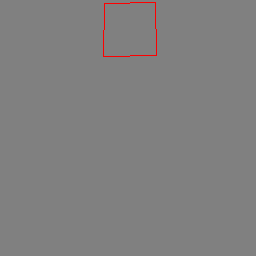

In [23]:
pred_quad = res.predict(start=observations.size, end=observations.size + 7).reshape(-1, 2)
img = Image.new('RGB', (256,256), color='gray')
imgd = ImageDraw.ImageDraw(img)
draw_quad(imgd, pred_quad)
img

In [40]:
# Degree of Freedom = lags + period
res.diagnostic_summary?

Signature: res.diagnostic_summary()
Docstring:
Returns a summary containing standard model diagnostic tests

Returns
-------
Summary
    A summary instance with panels for serial correlation tests,
    normality tests and heteroskedasticity tests.

See Also
--------
test_serial_correlation
    Test models residuals for serial correlation.
test_normality
    Test models residuals for deviations from normality.
test_heteroskedasticity
    Test models residuals for conditional heteroskedasticity.
File:      /opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py
Type:      method


No handles with labels found to put in legend.


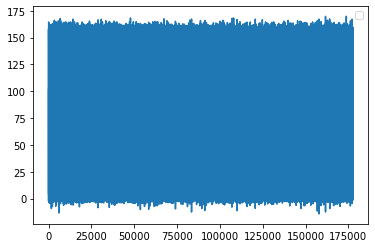

In [41]:
res.plot_predict()
plt.show()

In [20]:
[x for x in dir(res) if not x.startswith('__')]

['_ar_lags',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_df_model',
 '_get_robustcov_results',
 '_hold_back',
 '_lag_repr',
 '_max_lag',
 '_n_totobs',
 '_nobs',
 '_params',
 '_use_t',
 'aic',
 'ar_lags',
 'arfreq',
 'bic',
 'bse',
 'conf_int',
 'cov_params',
 'cov_params_default',
 'data',
 'df_model',
 'df_resid',
 'diagnostic_summary',
 'f_test',
 'fittedvalues',
 'forecast',
 'fpe',
 'get_prediction',
 'hqic',
 'initialize',
 'llf',
 'load',
 'model',
 'nobs',
 'normalized_cov_params',
 'params',
 'plot_diagnostics',
 'plot_predict',
 'predict',
 'pvalues',
 'remove_data',
 'resid',
 'roots',
 'save',
 'scale',
 'sigma2',
 'summary',
 't_test',
 't_test_pairwise',
 'test_heteroskedasticity',
 'test_normality',
 'test_serial_correlation',
 'tvalues',
 'use_t',
 'wald_test',
 'wald_test_terms']

In [46]:
res.params.shape

(9,)

In [44]:
res.get_prediction?

Signature:
res.get_prediction(
    start=None,
    end=None,
    dynamic=False,
    exog=None,
    exog_oos=None,
)
Docstring:
Predictions and prediction intervals

Parameters
----------
params : array_like
    The fitted model parameters.
start : int, str, or datetime, optional
    Zero-indexed observation number at which to start forecasting,
    i.e., the first forecast is start. Can also be a date string to
    parse or a datetime type. Default is the the zeroth observation.
end : int, str, or datetime, optional
    Zero-indexed observation number at which to end forecasting, i.e.,
    the last forecast is end. Can also be a date string to
    parse or a datetime type. However, if the dates index does not
    have a fixed frequency, end must be an integer index if you
    want out-of-sample prediction. Default is the last observation in
    the sample. Unlike standard python slices, end is inclusive so
    that all the predictions [start, start+1, ..., end-1, end] are
    returned.